In [12]:
# google colab の場合は、この下のコメントアウトを外す
# ! pip install pykalman

In [25]:

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
import pykalman
import sklearn
from sklearn.metrics import mean_absolute_error, mean_squared_error

DataFrame.shape: (309, 2)


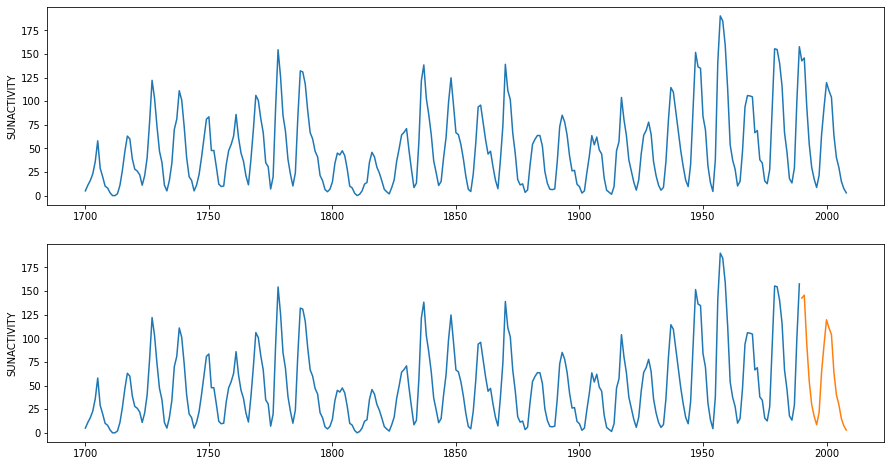

In [19]:
# statsmodelsライブラリのサンプルデータ・太陽黒点数のデータフレームを作成
sunspot_df = sm.datasets.sunspots.load_pandas().data # statsmodels.api.datasets.sunspots.load_pandas().data
print('DataFrame.shape:', sunspot_df.shape) # データフレームの形状を表示
# 時系列モデルの学習と性能検証のため、データを学習用(先頭から270件)と検証用(271件目以降)に分割
train_data = sunspot_df[:290]
test_data = sunspot_df[290:]

fig, ax = plt.subplots(2, 1, figsize=(15,8)) # 折れ線グラフで表示
ax[0].set_ylabel('SUNACTIVITY')
g = ax[0].plot(sunspot_df.YEAR, sunspot_df.SUNACTIVITY) # サンプルデータを表示
ax[1].set_ylabel('SUNACTIVITY')
g = ax[1].plot(train_data.YEAR, train_data.SUNACTIVITY) # 学習用データを表示
g = ax[1].plot(test_data.YEAR, test_data.SUNACTIVITY) # 検証用データを表示

In [15]:
# 推移行列などの初期化
## 島田直樹、時系列解析(共立出版)のサンプルコートから引用
def FGHset(n_dim_trend, n_dim_obs=1, n_dim_series=0, Q_sigma2=10):
    n_dim_Q = (n_dim_trend!=0) + (n_dim_series!=0)
    if n_dim_series>0:
        n_dim_state = n_dim_trend + n_dim_series - 1
    else:
        n_dim_state = n_dim_trend
    
    # 行列の初期化
    G = np.zeros((n_dim_state, n_dim_Q))
    F = np.zeros((n_dim_state, n_dim_state))
    H = np.zeros((n_dim_obs, n_dim_state))
    Q = np.eye(n_dim_Q) * Q_sigma2
    
    ## トレンドモデルのブロック行列の構築
    G[0,0] = 1
    H[0,0] = 1
    if n_dim_trend==1: 
        F[0,0] = 1
    elif n_dim_trend==2:
        F[0,0] = 2
        F[0,1] = -1
        F[1,0] = 1
    elif n_dim_trend==3:
        F[0,0] = 3
        F[0,1] = -3
        F[0,2] = 1
        F[1,0] = 1
        F[2,1] = 1
        
    start_elem = n_dim_trend
    start_col = n_dim_trend
    # 季節調整成分のブロック行列の構築
    if n_dim_series>0:
        G[start_elem, 1] = 1
        H[0, start_elem] = 1
        for i in range(n_dim_series-1): 
            F[start_elem, start_elem+i] = -1
        for i in range(n_dim_series-2): 
            F[start_elem+i+1, start_elem+i] = 1
    
    # PyKalmanのQはG.dot(Q).dot(G.T)を想定しているためQをupdate
    Q = G.dot(Q).dot(G.T)
    
    return n_dim_state, F, H, Q

In [27]:
# プログラムを見やすくするために観測値の変数を用意
observations = train_data.SUNACTIVITY.values

# カルマンフィルタを作成
n_dim_state, F, H, Q = FGHset(2,1,12) # ハイパーパラメータを準備
kf = pykalman.KalmanFilter(transition_matrices=F,  # 状態の推移行列
                           transition_covariance=Q,  # 状態ノイズの分散共分散行列
                           observation_matrices=H)  # 観測値の行列
emed_kf = kf.em(observations, n_iter=10, em_vars='all')  # ハイパーパラメータを更新
smoothed_state_means, smoothed_state_covs = emed_kf.smooth(observations) # フィルタリング+平滑化
train_pred = smoothed_state_means.dot(H.T)

# カルマンフィルタで予測
test_pred = np.empty(len(test_data)) # 予測値を格納するベクトルを用意
current_state = smoothed_state_means[-1]
current_cov = smoothed_state_covs[-1]
for i in range(len(test_data)):
    current_state, current_conv = emed_kf.filter_update(current_state, current_cov, observation=None)
    test_pred[i] = kf.observation_matrices.dot(current_state)

## 学習用データの区間と検証用データの区間の予測値の平均絶対誤差(MAE)と平均二乗誤差(MSE)
print('train_data MAE:', 
      mean_absolute_error(train_data.SUNACTIVITY.values, train_pred))
print('train_data MSE:', 
      mean_squared_error(train_data.SUNACTIVITY.values, train_pred))
print('test_data MAE:', 
      mean_absolute_error(test_data.SUNACTIVITY.values, test_pred))
print('test_data MSE:', 
      mean_squared_error(test_data.SUNACTIVITY.values, test_pred))

train_data MAE: 0.37226505699262286
train_data MSE: 0.29146853554426205
test_data MAE: 14.27264024916009
test_data MSE: 286.6474021243165


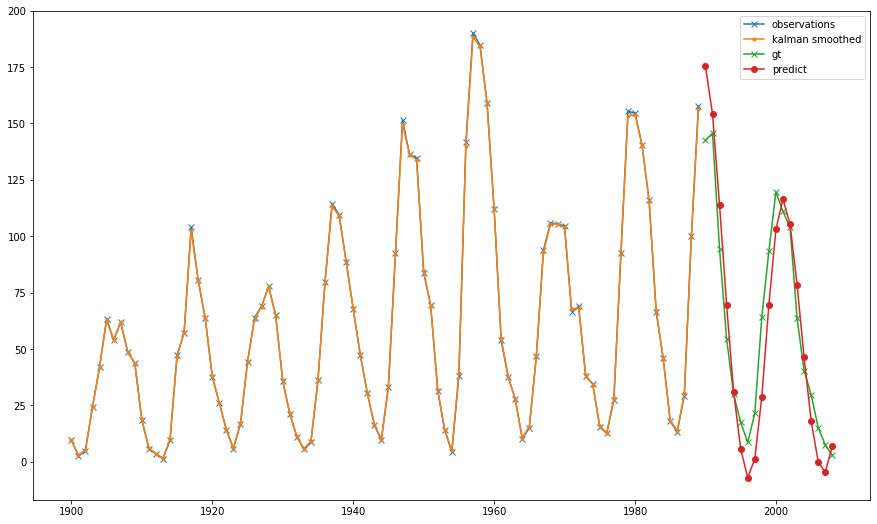

In [ ]:

# 観測値とカルマンフィルタによる予測値をグラフで表示 (見やすくするために、1900年以降を表示)
plt.figure(figsize=(15, 9))
plt.plot(train_data[200:].YEAR, observations[200:], marker='x', label="observations")
plt.plot(train_data[200:].YEAR, train_pred[200:], marker='.', label="kalman smoothed")
plt.plot(test_data.YEAR, test_data.SUNACTIVITY, marker='x', label="gt")
plt.plot(test_data.YEAR, test_pred, marker='o', label="predict")
plt.legend()
plt.show()